Code from OpenAI Cookbook
https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [1]:
import json
import os
import tiktoken # for token counting
import numpy as np
from collections import defaultdict
import openai
import pandas as pd
import matplotlib.pyplot as plt
import requests
import base64
import logging


Validate Data Format

In [168]:
# load jsonl file
data_path = "data/finetuning_data/small_training_data.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 10
First example:
{'role': 'system', 'content': 'Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Reply with numerical\n         values only.'}
{'role': 'user', 'content': 'Amendment of the MFF 2014-2020: PURPOSE: to amend Regulation (EU, Euratom) No 1311/2013 laying down the multiannual financial framework for the years 2014-2020. PROPOSED ACT: Council Regulation. ROLE OF THE EUROPEAN PARLIAMENT: Council may adopt the act only if Parliament has 

In [19]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [169]:
# HELPER FUNCTIONS

# cl100k_base is the tokenizer used by ChatGPT3.5 and ChatGPT4
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            # .encode returns the list of tokens (so that you can count them with len())
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [170]:
# check for missing data, distribution of messages in each conversation,
# distribution of tokens per conversation, print token limit warnings

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
#print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 93, 94
mean / median: 93.9, 94.0
p5 / p95: 93.9, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


Estimate costs

In [171]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~10745 tokens that will be charged for during training
By default, you'll train for 10 epochs on this dataset
By default, you'll be charged for ~107450 tokens


Upload validated files to OpenAI API

In [172]:
# upload validated data file to OpenAI API
# set OPENAI_API_KEY in environment variables

client = openai.OpenAI(api_key=os.environ['TestKey3'])

train_upload = client.files.create(
  file=open("data/finetuning_data/small_training_data.jsonl", "rb"),
  purpose="fine-tune"
)
val_upload = client.files.create(
  file=open("small_validation_data.jsonl", "rb"),
  purpose="fine-tune"
)
print("Uploaded training file id:", train_upload.id)
print("Uploaded validation file id:", val_upload.id)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"


Uploaded training file id: file-kiZzQ1c7BkZloX1X8b6YiOOQ
Uploaded validation file id: file-GT23vgbLI3dpl5tzORnzqMr2


To Do:
- Was sind die verschiedenen Arten von Loss?
- Was sind die Steps? Wie kriege ich den loss runter?
- eine Art finden, loss usw kontrollieren - Website
- einen Algorithmus zum Testen verschiedener Hyperparameter bauen
- Ergbenis verschiedenerHyperparameter visualisieren

Create Fine-Tuning Job via OpenAI Software Development Kit

In [134]:
import itertools
learning_rate_multiplier = [0.5, 1, 2, 3]
n_epochs = [1, 2, 3]
batch_size = [1, 2, 4, 8]

# test various hyperparameters
results = []
for lr, epoch, batch in itertools.product(learning_rate_multiplier, n_epochs, batch_size):
  try:
    response = client.fine_tuning.jobs.create(
      training_file=train_upload.id, # file id returned after upload to API 
      validation_file=val_upload.id, # file id returned after upload to API
      model="gpt-3.5-turbo",
      suffix="small",
      seed=124,
      hyperparameters={
      "n_epochs": 3,
      "batch_size": 1,
      "learning_rate_multiplier": lr
      }
    )
    job_id = response.id
    # Store the response and hyperparameters for later analysis
    results.append({
          "job_id": job_id,
          "hyperparameters": {
              "learning_rate_multiplier": lr,
              "n_epochs": epoch,
              "batch_size": batch
          },
          "status": response['status'],
          "result_files": response['result_files']
          })
  
      
  except Exception as e:
    print(f"An error occurred for hyperparameters (lr={lr}, epoch={epoch}, batch={batch}): {e}")


# Retrieve the state of a fine-tune
for result in results:
    job_id = result["job_id"]
    client.fine_tuning.jobs.retrieve(job_id)
    print(f'Fine-tunning model with jobID: {response.id}.')
    print(f"Hyperparameters: {response.hyperparameters }")
    print(f"Training Status: {response.status}")
    print(f"Result Files: {response.result_files}")
    # monitor training progress, get ft events
    event_ls = client.fine_tuning.jobs.list_events(
        fine_tuning_job_id=job_id,
        limit=10
        )

# print each event individually 
for i, event in enumerate(event_ls, start = 1):
    print(f"Event {i}: {event}")

# print result file id
result_files = client.fine_tuning.jobs.retrieve(job_id).result_files
for i, file_id in enumerate(result_files, start = 1):
    if len(result_files) > 1 and i == 1:
        print(f"Multiple result files found, {len(result_files)} in total.")
    print(f"Result file {i}: {file_id}")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-to5GOd9M0AK2YbxnKQoBMT5B "HTTP/1.1 200 OK"


Fine-tunning model with jobID: ftjob-to5GOd9M0AK2YbxnKQoBMT5B.
Hyperparameters: Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=0.01)
Training Status: validating_files
Validation Status: []


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-to5GOd9M0AK2YbxnKQoBMT5B/events?limit=10 "HTTP/1.1 200 OK"


Event: FineTuningJobEvent(id='ftevent-BA7k3FMiRCiv6G9ZVcPHbB5h', created_at=1721495042, level='info', message='Validating training file: file-0yosrxT70cieHFEhDtzcoFlj and validation file: file-NeUvOylfyM6dVnN3ORZlhULm', object='fine_tuning.job.event', data={}, type='message')
Event: FineTuningJobEvent(id='ftevent-kL4S50vJMRIqGLM1BkDHV1Tq', created_at=1721495042, level='info', message='Created fine-tuning job: ftjob-to5GOd9M0AK2YbxnKQoBMT5B', object='fine_tuning.job.event', data={}, type='message')


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-to5GOd9M0AK2YbxnKQoBMT5B/events?limit=10&after=ftevent-kL4S50vJMRIqGLM1BkDHV1Tq "HTTP/1.1 200 OK"


Getting Metrics / Evaluation

In [165]:
# create empty csv files with columnn names train_loss, val_loss, train_ppl, val_ppl
with open("decoded_content.csv", "w") as f:	
    f.write("train_loss, train_accuracy, valid_loss, valid_mean_token_accuracy\n")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def fix_base64_padding(base64_str):
    """Fix the padding of a Base64 encoded string."""
    missing_padding = len(base64_str) % 4
    if missing_padding:
        base64_str += '=' * (4 - missing_padding)
    return base64_str

def get_ft_results(file_id):
    """
    Given a result_files id of a finished fine-tuning job, a request is made to the OpenAI API
    to retrieve the content of the file. Content is decoded from Base64 and saved to a 
    csv file, which can be later loaded as a pandas DataFrame.
    """
    headers = {'Authorization': f'Bearer {os.environ['TestKey3']}'}
    try:
        response = requests.get(f"https://api.openai.com/v1/files/{file_id}/content", headers=headers)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx and 5xx)
        logger.info("Received response for file content.")
        if response.content:
            try:
                # Parse the JSON content
                decoded_content = base64.b64decode(response.content).decode('utf-8')
                decoded_content = fix_base64_padding(decoded_content)
                logger.info("Parsed JSON content successfully.")
                with open("decoded_content.csv", "w") as f:
                    f.write(decoded_content)
                logger.info("File 'decoded_content.csv' written successfully.")
            except (ValueError, base64.binascii.Error) as e:
                # Handle the case where the response is not valid JSON
                logger.error("Response content could not be parsed as JSON")
                logger.error(f"Exception: {e}")
                logger.error(response.content)
        else:
            logger.error("Response content is empty")
    except requests.exceptions.HTTPError as http_err:
        logger.error(f"HTTP error occurred: {http_err}")
    except requests.exceptions.RequestException as err:
        logger.error(f"Error occurred: {err}")
    return "decoded_content.csv"

def get_checkpoint_results(job_id):
    """
    Given a job_id of a finished fine-tuning job, a request is made to the OpenAI API
    to retrieve the checkpoints which have been saved during the fine-tuning process. 
    Content is decoded from Base64 and saved to a csv file, which can be later loaded 
    as a pandas DataFrame.
    """
    headers = {'Authorization': f'Bearer {os.environ['TestKey3']}'}
    try:
        response = requests.get(f"https://api.openai.com/v1/fine_tuning/jobs/{job_id}/checkpoints", headers=headers)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx and 5xx)
        if response.content:
            try:
                # Decode the json encoded content
                decoded_content = response.content.decode('utf-8')
                logger.info("Decoded response content successfully.")
                # Normalize the Json content to a df
                decoded_content_df = json.dumps(json.loads(decoded_content), indent=4)
            except (ValueError, json.JSONDecodeError) as e:
                # Handle the case where the response is not valid JSON
                logger.error("Response content could not be parsed as JSON")
                logger.error(f"Exception: {e}")
                logger.error(f"Content: {response.content}")
        else:
            logger.error("Response content is empty")
    except requests.exceptions.HTTPError as http_err:
        logger.error(f"HTTP error occurred: {http_err}")
    except requests.exceptions.RequestException as err:
        logger.error(f"Error occurred: {err}")
    return decoded_content_df

metrics_df = pd.read_csv(get_ft_results(result_files[0]))
display(metrics_df.head())

checkpoints_df = get_checkpoint_results(job_id)
print(checkpoints_df)

INFO:__main__:Received response for file content.
INFO:__main__:Parsed JSON content successfully.
INFO:__main__:File 'decoded_content.csv' written successfully.


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.49278,0.63218,2.59928,0.63218
1,2,2.48728,0.63218,2.56662,0.64368
2,3,2.42869,0.63218,2.47827,0.62069
3,4,2.32884,0.63218,2.39103,0.62069
4,5,2.72216,0.65517,2.93167,0.65517


INFO:__main__:Decoded response content successfully.


{
    "object": "list",
    "data": [
        {
            "object": "fine_tuning.job.checkpoint",
            "id": "ftckpt_lTKUgWzKUcVU60Jgj2W7SeP3",
            "created_at": 1721495241,
            "fine_tuned_model_checkpoint": "ft:gpt-3.5-turbo-0125:lse:small:9n7qIWZT",
            "fine_tuning_job_id": "ftjob-to5GOd9M0AK2YbxnKQoBMT5B",
            "metrics": {
                "step": 30,
                "train_loss": 2.3939671516418457,
                "train_mean_token_accuracy": 0.6321839094161987,
                "valid_loss": 2.503386935968509,
                "valid_mean_token_accuracy": 0.6436781609195402
            },
            "step_number": 30
        },
        {
            "object": "fine_tuning.job.checkpoint",
            "id": "ftckpt_pshTLHLqeCPFwG27qjOGkC5d",
            "created_at": 1721495214,
            "fine_tuned_model_checkpoint": "ft:gpt-3.5-turbo-0125:lse:small:9n7qILz1:ckpt-step-20",
            "fine_tuning_job_id": "ftjob-to5GOd9M0AK2YbxnKQoBMT5

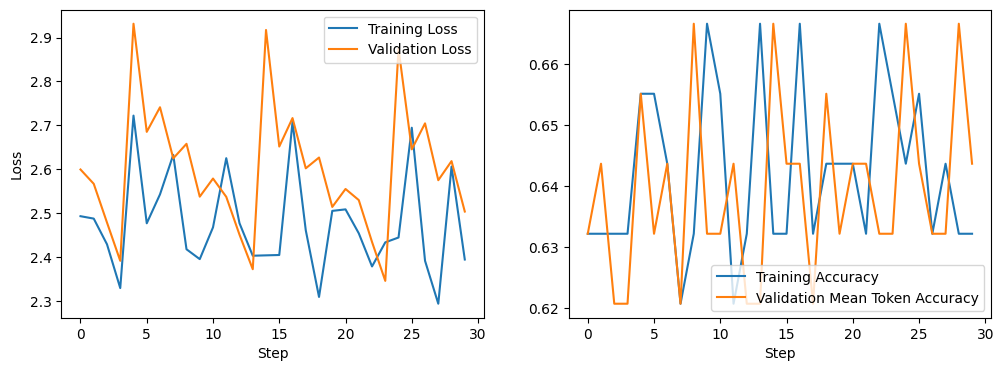

In [166]:
# plot the training loss and validation loss as lines in one plot
# print two plots next to eachtother
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(metrics_df["train_loss"], label="Training Loss")
ax[0].plot(metrics_df["valid_loss"], label="Validation Loss")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(metrics_df["train_accuracy"], label="Training Accuracy")
ax[1].plot(metrics_df["valid_mean_token_accuracy"], label="Validation Mean Token Accuracy")
ax[1].set_xlabel("Step")
ax[1].legend()

plt.show()

In [ ]:
# List the checkpoints of the model
# and save output in a json
# with the following curl command
# curl https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/checkpoints \ -H "Authorization: Bearer {API_key}" -o checkpoint_output.json

Cancel or track a fine-tune job or delete a model

In [ ]:
# List 10 fine-tuning jobs
client.fine_tuning.jobs.list(limit=10)

# Retrieve the state of a fine-tune
client.fine_tuning.jobs.retrieve("ftjob-abc123")

# Cancel a job
client.fine_tuning.jobs.cancel("ftjob-abc123")

# List up to 10 events from a fine-tuning job
client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-abc123", limit=10)

# Delete a fine-tuned model (must be an owner of the org the model was created in)
client.models.delete("ft:gpt-3.5-turbo:acemeco:suffix:abc123")

Using fine-tuned model via Playground or via code

In [167]:
# make a request to the new model
completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:lse:small:9n7qIWZT",
  messages=[
    {"role": "system", "content": "Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         the above legislative proposal, predict the percentage of votes in favour \n         from each party group in the European Parliament. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments."},
    {"role": "user", "content": "EC-Mauritania Fisheries Partnership Agreement: fishing opportunities and financial contribution. Extension of the Protocol: CONTENT: to conclude the Agreement in the form of an exchange of letters between the European Union and the Islamic Republic of Mauritania concerning the extension to the Protocol setting out the fishing opportunities and financial contribution provided for in the Fisheries Partnership Agreement between the European Community and the Islamic Republic of Mauritania, expiring on 15 November 2019. PROPOSED ACT: Council Decision. ROLE OF THE EUROPEAN PARLIAMENT: Council may adopt the act only if Parliament has given its consent to the act. BACKGROUND: in accordance with a Council Decision, the Agreement in the form of an exchange of letters concerning the extension of the Protocol setting out the fishing opportunities and financial contribution provided for in the Fisheries Partnership Agreement between the European Community and Mauritania, expiring on 15 November 2019, was signed. It is now necessary for it to be approved. CONTENT: the draft Council Decision concerns the approval, on behalf of the Union, of the Agreement in the form of an Exchange of Letters between the European Union and the Islamic Republic of Mauritania concerning the extension of the Protocol setting out the fishing opportunities and financial contribution provided for in the Fisheries Partnership Agreement between the European Community and the Islamic Republic of Mauritania, expiring on 15 November 2019. The objective of the Agreement in the form of an Exchange of Letters is to enable the European Union and Mauritania to continue to work together on promoting a sustainable fisheries policy and the sound exploitation of fisheries resources in Mauritanian waters and to allow Union vessels to carry out their fishing activities in those waters."}
  ]
)
print(completion.choices[0].message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content="Based on the information provided, as an expert predicting European Parliament voting patterns, here are the predicted percentages of votes in favour from each party group in the European Parliament for the proposed act on the extension of the EC-Mauritania Fisheries Partnership Agreement:\n\n1. European People's Party (EPP): 70% in favour\n   - The EPP group tends to support agreements that promote economic opportunities, such as fisheries partnerships, as they align with principles of international cooperation and economic growth.\n\n2. Socialists and Democrats (S&D): 60% in favour\n   - The S&D group is likely to support agreements that focus on sustainability and cooperation, as indicated by the mention of promoting sustainable fisheries policies and sound exploitation of resources in the legislative proposal.\n\n3. Renew Europe (RE): 80% in favour\n   - The RE group generally supports agreements that facilitate trade and partnerships with other regio

ChatCompletionMessage(content="Based on the information provided, as an expert predicting European Parliament voting patterns, here are the predicted percentages of votes in favour from each party group in the European Parliament for the proposed act on the extension of the EC-Mauritania Fisheries Partnership Agreement:\n\n1. European People's Party (EPP): 70% in favour\n
 - The EPP group tends to support agreements that promote economic opportunities, such as fisheries partnerships, as they align with principles of international cooperation and economic growth.\n\n2. Socialists and Democrats (S&D): 60% in favour\n 
 - The S&D group is likely to support agreements that focus on sustainability and cooperation, as indicated by the mention of promoting sustainable fisheries policies and sound exploitation of resources in the legislative proposal.\n\n3. Renew Europe (RE): 80% in favour\n 
 - The RE group generally supports agreements that facilitate trade and partnerships with other regions or countries, which is in line with the extension of fishing opportunities outlined in the proposal.\n\n4. Greens/European Free Alliance (Greens/EFA): 50% in favour\n 
 - The Greens/EFA group may have concerns about the environmental impact of fisheries agreements, but their support could be influenced by the emphasis on sustainable fisheries in the proposal.\n\n5. European Conservatives and Reformists (ECR): 75% in favour\n 
 - The ECR group is likely to support agreements that promote economic benefits and opportunities for European businesses, such as access to fishing waters in Mauritania.\n\n6. Identity and Democracy (ID): 40% in favour\n
  - The ID group may have reservations about international agreements that involve financial contributions, but their support could be influenced by economic interests.\n\n
Based on these predictions, a General majority (requiring a simple majority of votes cast) is likely to support the legislation due to its relevance to economic cooperation, sustainability, and promoting fisheries opportunities. The wording and framing of the law emphasize collaboration for sustainable fisheries policies, which can appeal to a broad spectrum of political ideologies within the European Parliament.", role='assistant', function_call=None, tool_calls=None)

In [41]:
# Convert list ouput back to a dataframe

response_ls = ['ECR%:0.839, EPP%:0.898, EFD/IDG%:0.562, Greens/EFA%:0.932, NI%:0.294, REG%:0.892, S&D%:0.89, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.563, EPP%:0.784, EFD/IDG%:0.269, Greens/EFA%:0.815, NI%:0.167, REG%:0.759, S&D%:0.803, The Left%:0.688, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.59, EPP%:0.802, EFD/IDG%:0.188, Greens/EFA%:0.875, NI%:0.154, REG%:0.844, S&D%:0.815, The Left%:0.62, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.636, EPP%:0.787, EFD/IDG%:0.295, Greens/EFA%:0.852, NI%:0.273, REG%:0.795, S&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Maj875, NI%:0.154, REG%:0.844, S&D%:0.815, The Left%:0.62, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.636, EPP%:0.787, EFD/IDG%:0.295, Greens/EFA%:0.852, NI%:0.273, REG%:0.795, S&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left MajS&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Co, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Coority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Consensus:0', 'ECR%:0.714, EPP%:0.728, EFD/IDG%:0.375, Greens/EFA%:0.885, NI%:0.219, REG%:0.846, S&D%:0.786, The Left%:0.609, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.867, EPnsensus:0', 'ECR%:0.714, EPP%:0.728, EFD/IDG%:0.375, Greens/EFA%:0.885, NI%:0.219, REG%:0.846, S&D%:0.786, The Left%:0.609, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.867, EPP%:0.901, EFD/IDG%:0.438, Greens/EFA%:0.81, NI%:0.154, REG%:0.839, S&D%:0.854, The Left%:0.731, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.898, EPP%:0.935, EFD/IDG%:0.625, Greens/EFA%:0.957, NI%:0.542, REG%:0.865, S&D%:0.901, The Left%:0.766, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0']
# Function to convert each string into a dictionary
def parse_string_ls_to_dict(s):
    result = {}
    # delete all ' from string
    s = s.replace("'", "")
    # split key value paris from each other
    for item in s.split(', '):
        # split party names from values
        parts = item.split(':')
        if len(parts) == 2:
            # turn key value pairs into dictionary
            key, value = parts
            result[key] = value
        else:
            print(f"Skipping incorrectly formatted item: {item}")
    return result

# Convert list of strings to list of dictionaries
response_dicts = [parse_string_ls_to_dict(item) for item in response for reponse in response_ls]

# Convert list of dictionaries to DataFrame
response_df = pd.DataFrame(response_dicts)

# Convert numeric columns to float
response_df = df.apply(pd.to_numeric, errors='ignore')

display(response_df)

# Calculate accuracy
acc = fu.get_accuracy_df(response_df, 0.05)

Skipping malformed item: Left Maj875
Skipping malformed item: Co
20


C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_3048\2671900495.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,ECR%,EPP%,EFD/IDG%,Greens/EFA%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus,Left MajS&D%,Coority,EPnsensus
0,0.839,0.898,0.562,0.932,0.294,0.892,0.890,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
1,0.563,0.784,0.269,0.815,0.167,0.759,0.803,0.688,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,0.590,0.802,0.188,0.875,0.154,0.844,0.815,0.620,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,0.636,0.787,0.295,0.852,0.273,0.795,0.813,0.568,1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
5,0.828,0.898,0.303,0.080,0.154,0.844,0.815,0.620,1.0,0.0,0.0,0.0,NaN,NaN,NaN
6,0.636,0.787,0.295,0.852,0.273,0.795,0.813,0.568,1.0,0.0,0.0,0.0,NaN,NaN,NaN
7,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
8,0.828,0.898,0.303,0.080,0.156,0.830,0.772,0.568,1.0,0.0,0.0,0.0,0.813,NaN,NaN
9,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
